This is the driver program for the ARIMA process. 

- It starts with testing stationarity.
- Then it runs a grid search for the best parameters. It returns the best parameters and we use those going forward.
- Then we summarize residual errors for the model.
- Then we summarize residual errors from bias corrected forecasts.
- Plots test vs prediction scores
- Saves finalized model to file
- Loads the finalized model and makes a prediction. This proves that it works.
- Then finally we forecast for the balance of the year.

In [1]:
# import libraries
import pandas as pd
import pickle
import stationarity as st
import load_data as ld
import arima_grid_search as ags
import summarize
import test_prediction_save_forecast_1day as tpsf1
import multi_step_forecast as msf

In [2]:
# Prepare arguments for driver
arg_dict = {'file_name_1': r'data\all_df.csv',
            'file_name_2': r'C:\Users\linds\OneDrive\mystuff\GitHub\covid\data\country_codes_edited.csv',
            'feature': 'Alpha_3',
            'place': 'CAN',
            'dependent_variable': 'Deaths',
            'path': r'C:\Users\linds\OneDrive\mystuff\GitHub\COVID-19\csse_covid_19_data\csse_covid_19_daily_reports',
            'p_values': range(0,3),
            'd_values': range(0,3),
            'q_values': range(0,3),
            'split_value': .5,
            'bias': 0,
            'date': '12-31-2020'}

In [3]:
# Need to load John Hopkins data
df, li_set = ld.driver(arg_dict)

# Look at all of the available columns
# Remember Alpha_3 is the country_code. That is also available.
df.head(1)

,Date_,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key
0,2020-01-22,NaN,NaN,Anhui,Mainland China,1/22/2020 17:00,NaN,NaN,1.0,NaN,NaN,NaN,NaN


The "data date" is 2020-05-20 00:00:00

ADF Statistic: -1.303924
p-value: 0.627375
Critical Values:
	1%: -3.532
	5%: -2.906
	10%: -2.590


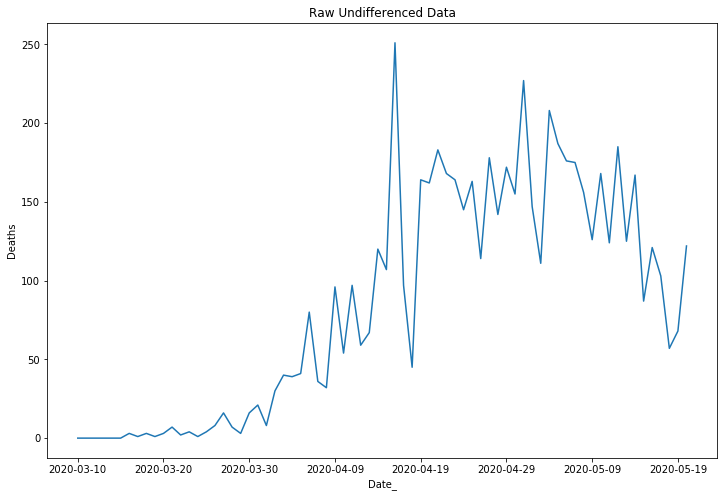

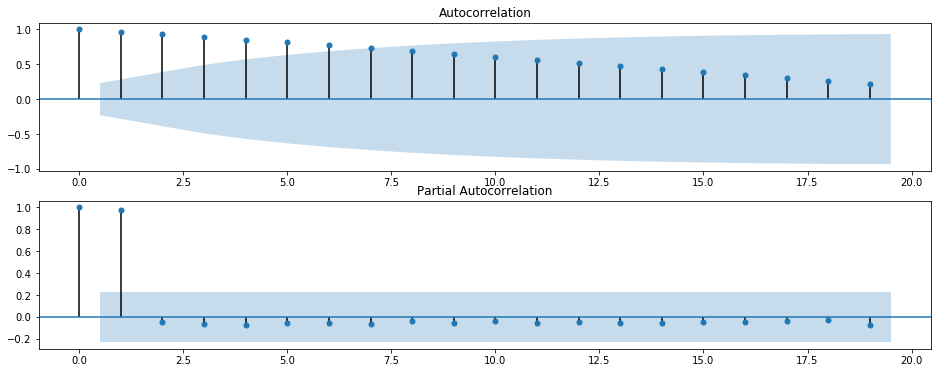

ARIMA(0, 0, 1) RMSE=2017.918
ARIMA(0, 1, 1) RMSE=106.884
ARIMA(0, 1, 2) RMSE=97.671
ARIMA(0, 2, 1) RMSE=48.787
ARIMA(0, 2, 2) RMSE=55.389
ARIMA(1, 0, 0) RMSE=152.818
ARIMA(1, 1, 0) RMSE=59.417
ARIMA(1, 2, 0) RMSE=55.230
ARIMA(2, 1, 0) RMSE=58.955
ARIMA(2, 2, 0) RMSE=55.387
ARIMA(2, 2, 1) RMSE=53.394
Best ARIMA(0, 2, 1) RMSE=48.787
RMSE: 48.787
                0
count   37.000000
mean     0.439214
std     49.458218
min   -102.435287
25%    -34.838690
50%      1.142898
75%     35.436967
max    152.076516


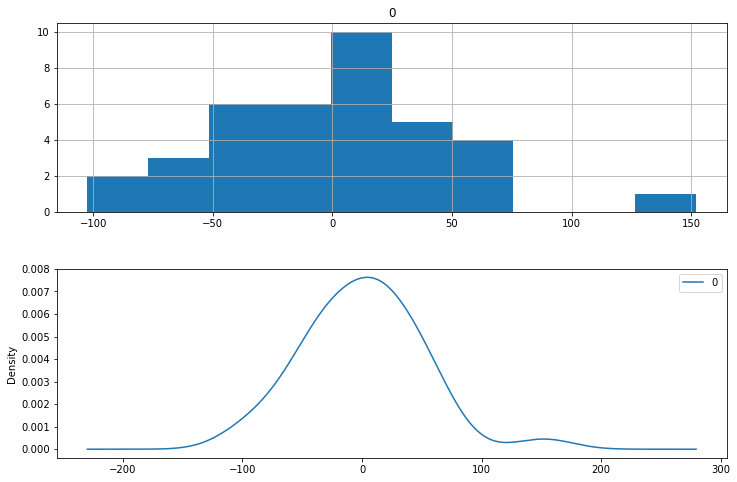


bias saved in arg_dict["bias"] for subsequent run is: 0.4392142965696074 

RMSE: 48.785
                  0
count  3.700000e+01
mean  -2.765356e-14
std    4.945822e+01
min   -1.028745e+02
25%   -3.527790e+01
50%    7.036837e-01
75%    3.499775e+01
max    1.516373e+02


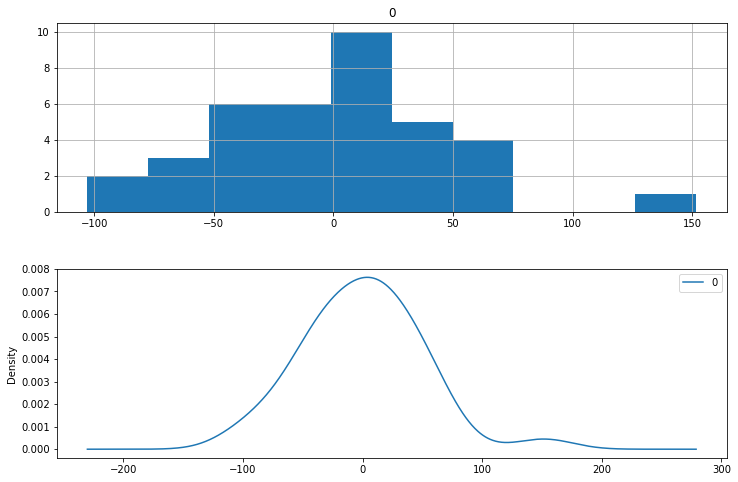


bias saved in arg_dict["bias"] for subsequent run is: -2.765355512147417e-14 



In [4]:
# Get the date of the last row in the file to establish the currency of the data.
print(f'The "data date" is {df["Date_"].iloc[-1]}\n')

# save arg_dict for subsequent independent processing
with open('arg_dict.pickle', 'wb') as handle:
    pickle.dump(arg_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Test for stationarity
df = st.driver(arg_dict)

# save df for subsequent independent processing
df.to_csv('df.csv')
      
# Grid search ARIMA parameters 
best_cfg = ags.driver(df, arg_dict)
arg_dict.update({'best_cfg': best_cfg})

# summarize residual errors for an ARIMA model and return bias
bias, test, predictions, model_fit = summarize.driver(df, arg_dict)
arg_dict.update({'bias': bias})

# save arg_dict for subsequent independent processing
with open('arg_dict.pickle', 'wb') as handle:
    pickle.dump(arg_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Rerun summarize, as bias adjusted
bias, test, predictions, model_fit = summarize.driver(df, arg_dict)
arg_dict.update({'test': test, 'predictions': predictions, 'model_fit': model_fit})

# save arg_dict for subsequent independent processing
with open('arg_dict.pickle', 'wb') as handle:
    pickle.dump(arg_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)


The predicted cumulative Deaths for CAN for tomorrow (input data plus 1 day) are 6,115


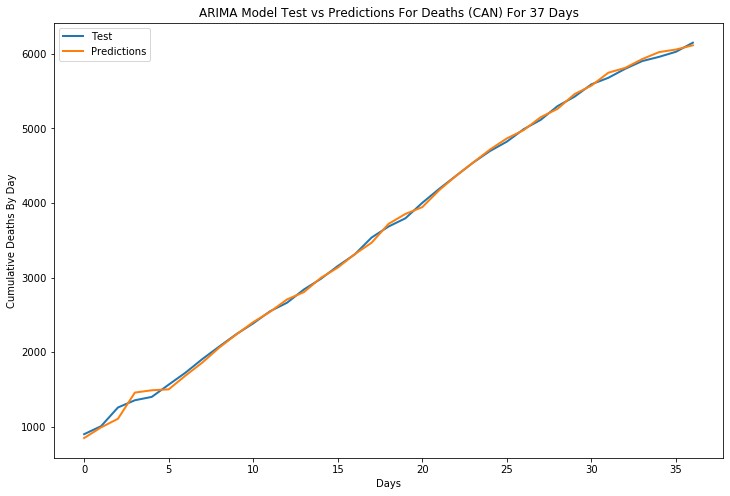

In [5]:
# Plot, save, and forecast
tpsf1.driver(arg_dict)

The CAN prediction is for 9,554 cumulative Deaths to occur by 2020-07-07 00:00:00


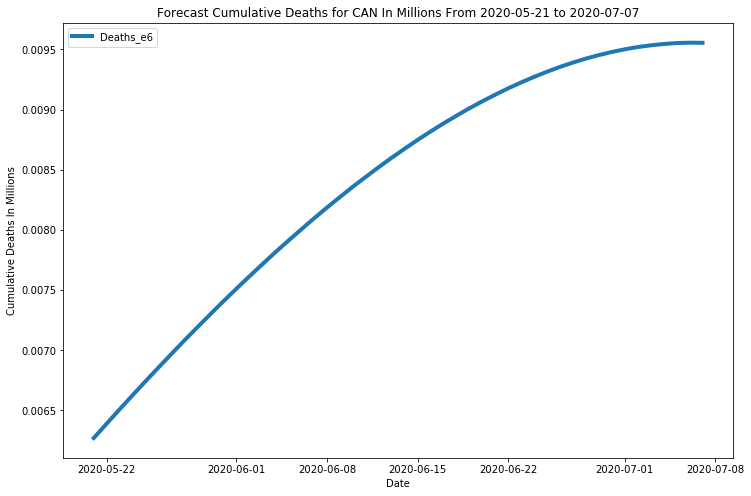

In [6]:
# Multi step forecast
df.index = pd.to_datetime(df.index)
forecast_df = msf.driver(df, arg_dict)

In [7]:
# Look at the last 5 days of the actual data
new_col_name = 'Daily_' + arg_dict["dependent_variable"]
df[new_col_name] = df[arg_dict['dependent_variable']] - df[arg_dict['dependent_variable']].shift(1)
df.tail()

,Deaths,Daily_Deaths
Date_,,
2020-05-16,5800.0,121.0
2020-05-17,5903.0,103.0
2020-05-18,5960.0,57.0
2020-05-19,6028.0,68.0
2020-05-20,6150.0,122.0


In [8]:
# First 5 days of forecasted data
forecast_df.head()

,Deaths,Deaths_e6
Date_,,
2020-05-21,6271.0,0.006271
2020-05-22,6391.0,0.006391
2020-05-23,6510.0,0.006510
2020-05-24,6627.0,0.006627
2020-05-25,6743.0,0.006743


In [9]:
forecast_df.Deaths.max()

9555.0

In [10]:
forecast_df.Deaths.idxmax()

Timestamp('2020-07-06 00:00:00')